In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
import kagglehub
path = kagglehub.dataset_download("naserabdullahalam/phishing-email-dataset")
print(f"Dataset downloaded to: {path}")

# Load the dataset and combine them
df1 = pd.read_csv(path + "/CEAS_08.csv")
df2 = pd.read_csv(path + "/Nazario.csv")
df3 = pd.read_csv(path + "/Nigerian_Fraud.csv")
df4 = pd.read_csv(path + "/SpamAssasin.csv")
df5 = pd.read_csv(path + "/Enron.csv")
df6 = pd.read_csv(path + "/Ling.csv")
df7 = pd.read_csv(path + "/phishing_email.csv")
print("Data loaded successfully.")

# Reformat the datasets to have consistent columns and combine them
df_group1 = pd.concat([df1, df2, df3, df4], ignore_index=True)
df_group1['text'] = df_group1['subject'].fillna('') + ' ' + df_group1['body'].fillna('')
df_group1 = df_group1[['text', 'label']]
# Display the first few rows of the combined DataFrame



# Rename columns for consistency
for df_temp in [df5, df6]:
    df_temp['text'] = df_temp['subject'].fillna('') + ' ' + df_temp['body'].fillna('')
df5 = df5[['text', 'label']]
df6 = df6[['text', 'label']]

df7.rename(columns={'text_combined': 'text'}, inplace=True)

df = pd.concat([df_group1, df5, df6, df7], ignore_index=True)
df.head()
print(f"Dataset shape before cleaning: {df.shape}")


# remove rows with missing values
df.dropna(inplace=True)

# remove duplicate rows
df.drop_duplicates(inplace=True)

# reset index after dropping rows
df.reset_index(drop=True, inplace=True)

print(f"Dataset shape after cleaning: {df.shape}")




/home/dustinvan/WORK/Summer-2025-ECE-597-Group1/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset downloaded to: /home/dustinvan/.cache/kagglehub/datasets/naserabdullahalam/phishing-email-dataset/versions/1
Data loaded successfully.
Dataset shape before cleaning: (164972, 2)
Dataset shape after cleaning: (164552, 2)


In [3]:
import re

def count_urls(text):
    """Count the number of URLs in the text"""
    url_pattern = r'http\S+|www\S+|https\S+|ftp\S+|\b\w+\.\w+\.\w+\S*'
    urls = re.findall(url_pattern, text, flags=re.IGNORECASE)
    return len(urls)

# Add URL count feature to the dataset
df['url_count'] = df['text'].apply(count_urls)

print(f"URL count feature added. Sample values:")
print(df[['text', 'url_count']].head())
print(f"\nURL count statistics:")
print(df['url_count'].describe())

# Add email length feature to the dataset
df['email_length'] = df['text'].apply(len)

print(f"Email length feature added. Sample values:")
print(df[['text', 'email_length']].head())
print(f"\nEmail length statistics:")
print(df['email_length'].describe())



URL count feature added. Sample values:
                                                text  url_count
0  Never agree to be a loser Buck up, your troubl...          1
1  Befriend Jenna Jameson \nUpgrade your sex and ...          1
2  CNN.com Daily Top 10 >+=+=+=+=+=+=+=+=+=+=+=+=...         24
3  Re: svn commit: r619753 - in /spamassassin/tru...        657
4  SpecialPricesPharmMoreinfo \nWelcomeFastShippi...          1

URL count statistics:
count    164552.000000
mean          2.294606
std          29.901052
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max        9198.000000
Name: url_count, dtype: float64
Email length feature added. Sample values:
                                                text  email_length
0  Never agree to be a loser Buck up, your troubl...           299
1  Befriend Jenna Jameson \nUpgrade your sex and ...           105
2  CNN.com Daily Top 10 >+=+=+=+=+=+=+=+=+=+=+=+=...          3939
3  Re: svn commit: r619753

In [4]:

import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS  

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove URLs
    # text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Remove stop words
    text = ' '.join([word for word in text.split() if word not in ENGLISH_STOP_WORDS])
    
    return text

df['text'] = df['text'].apply(preprocess_text)
print("Text preprocessing completed.")

Text preprocessing completed.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
from scipy.sparse import hstack

# Create TF-IDF features with 5000 features
print("Creating TF-IDF features...")
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_features = tfidf_vectorizer.fit_transform(df['text'])

# Get URL count features and reshape for concatenation
url_features = df['url_count'].values.reshape(-1, 1)

# Get email length features and reshape for concatenation
email_length_features = df['email_length'].values.reshape(-1, 1)



Creating TF-IDF features...
Combining TF-IDF features with URL count and email length...
Training logistic regression model...


In [33]:

# Combine TF-IDF features with URL count and email length
print("Combining TF-IDF features with URL count and email length...")


# Scale the email length features to match TF-IDF scale
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
url_features_scale = scaler.fit_transform(url_features)

# Combine TF-IDF features with URL count and scaled email length
combined_features = hstack([tfidf_features, url_features_scale])

print(combined_features.shape)
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    combined_features, df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

# Train logistic regression model
print("Training logistic regression model...")
lr_model = LogisticRegression(random_state=42, max_iter=1000, C=100, penalty='l2', solver='liblinear')
lr_model.fit(X_train, y_train)

# Make predictions
y_pred = lr_model.predict(X_test)

Combining TF-IDF features with URL count and email length...
(164552, 5001)
Training logistic regression model...


In [34]:

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nLogistic Regression with TF-IDF + URL Count Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))
print(f"\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Feature importance analysis
feature_names = list(tfidf_vectorizer.get_feature_names_out()) + ['url_count']
coefficients = lr_model.coef_[0]

# Get top 10 most important features
feature_importance = list(zip(feature_names, coefficients))
feature_importance.sort(key=lambda x: abs(x[1]), reverse=True)

print(f"\nTop 10 Most Important Features:")
for i, (feature, coef) in enumerate(feature_importance[:10]):
    print(f"{i+1}. {feature}: {coef:.4f}")



Logistic Regression with TF-IDF + URL Count Results:
Accuracy: 0.9929

Classification Report:
              precision    recall  f1-score   support

           0     0.9934    0.9917    0.9925     15765
           1     0.9924    0.9939    0.9932     17146

    accuracy                         0.9929     32911
   macro avg     0.9929    0.9928    0.9928     32911
weighted avg     0.9929    0.9929    0.9929     32911


Confusion Matrix:
[[15634   131]
 [  104 17042]]

Top 10 Most Important Features:
1. enron: -61.7809
2. wrote: -39.1374
3. uai: -35.3378
4. josemonkeyorg: 33.7427
5. opensuse: -31.4241
6. ierant: -29.5368
7. vince: -28.0776
8. investment: 26.9534
9. louise: -24.9222
10. kaminski: -23.0455



AUC Score: 0.9996


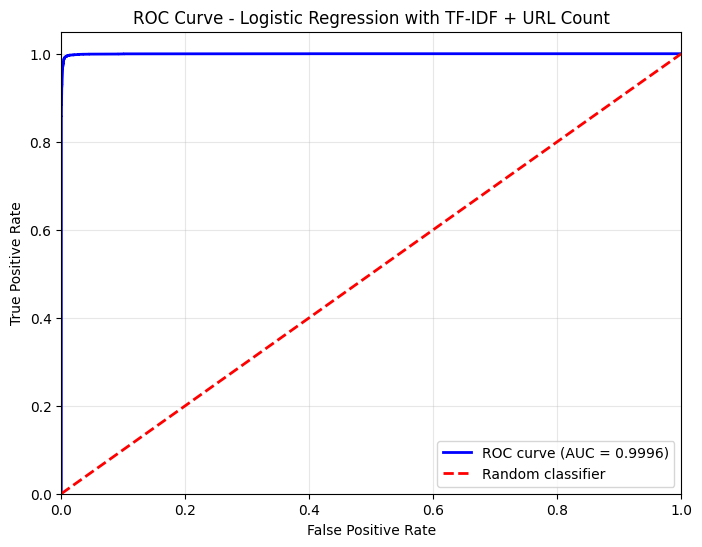

In [18]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Calculate AUC (Area Under the Curve)
y_pred_proba = lr_model.predict_proba(X_test)[:, 1]  # Get probability for positive class
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"\nAUC Score: {auc_score:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression with TF-IDF + URL Count')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
from sklearn.svm import SVC

svc_model_vect = SVC(kernel='linear', probability=True, random_state=42)
svc_model_vect.fit(X_train_vect, y_train_vect)
# svc_predictions_vect = svc_model_vect.predict(X_test_vect)

from sklearn.metrics import roc_auc_score
y_pred_proba = svc_model_vect.predict_proba(X_test_vect)[:, 1]
auc_score = roc_auc_score(y_test_vect, y_pred_proba)
print(f"\nAUC Score: {auc_score:.4f}")